In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [12]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [124]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

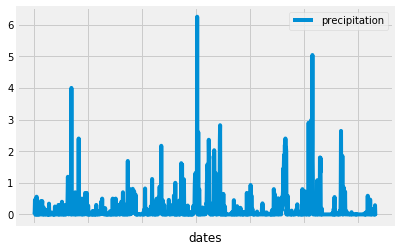

In [58]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
result = engine.execute("SELECT date, prcp FROM measurement WHERE date like '2017%' order by date desc;").fetchall()
#separate dates from result query
#separeate prcp from result query
df_months = pd.DataFrame({'dates': [x[0] for x in result], 'precipitation': [x[1] for x in result]})
df_months = df_months.dropna()
df_months.plot(x='dates',y='precipitation')
plt.show()

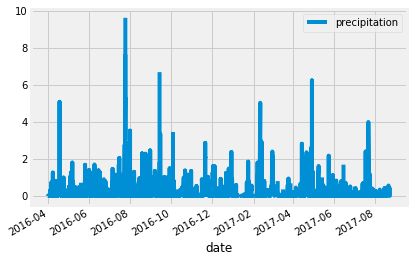

In [97]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
#map database tables to objects in python
Measurement = Base.classes.measurement
Station = Base.classes.station
###
tempo = session.query(Measurement.date, Measurement.prcp)
df = pd.DataFrame({'date': [x[0] for x in tempo], 'precipitation':[x[1] for x in tempo]})
#convert date object to ---> datetime
df['date'] = pd.to_datetime(df['date'])
mask = (df['date'] < dt.datetime(2017, 12, 31)) & (df['date'] >= dt.datetime(2016,4,1))
tmp = df.loc[mask]
tmp = tmp.sort_values(by='date', ascending=False)
tmp.plot(x='date',y='precipitation')
plt.show()


In [101]:
# Use Pandas to calcualte the summary statistics for the precipitation data
tmp.describe()

,precipitation
count,2831.000000
mean,0.193815
std,0.520103
min,0.000000
25%,0.000000
50%,0.020000
75%,0.150000
max,9.640000


In [111]:
# Design a query to show how many stations are available in this dataset?
station_available = session.query(func.count(Station.id))
station_available[0]

(9)

In [176]:
measure = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
id_stations = []
for x in measure:
    if x[1] > 1000:
        id_stations.append(x[0])
    print(x)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [188]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
avg_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station.in_(id_stations[0:1])).all()
for x in avg_temp:
    print(x)

(54.0, 85.0, 71.66378066378067)


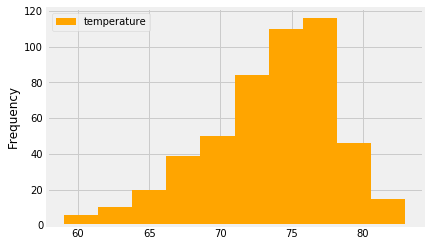

In [214]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_high = session.query(Measurement.tobs, Measurement.date).filter(Measurement.station == 'USC00519281') 
#and func.DATE(Measurement.date).between(dt.date(2017,8,31), dt.date(2017,4,1)) NOT WORKING!! :(

temp_df = pd.DataFrame({'date': [x[1] for x in temp_high], 'temperature': [x[0] for x in temp_high]})
temp_df['date'] = pd.to_datetime(temp_df['date'])
mask = (temp_df['date'] < dt.datetime(2017, 12, 31)) & (temp_df['date'] >= dt.datetime(2016,4,1))
temp_df = temp_df.loc[mask]
temp_df.head()
temp_df.plot.hist(x='date',y='temperature',color='orange')
plt.show()

In [217]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')
    end_date = dt.datetime.strptime(end_date, '%Y-%m-%d')
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))
#[(62.0, 69.57142857142857, 74.0)]

[(62.0, 69.4375, 74.0)]


In [220]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
#62.0 68.36585365853658 74.0
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 71.96551724137932, 78.0)]


71.96551724137932


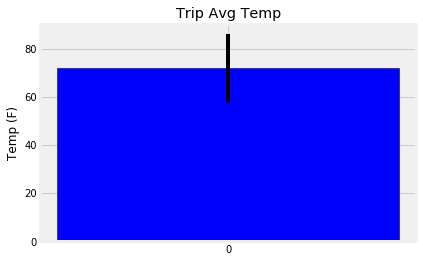

In [258]:

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
temp_vals = calc_temps('2017-02-28', '2017-03-05')
print(temp_vals[0][1])
fig, ax = plt.subplots()
bars = [temp_vals[0][1]]
r1 = np.arange(len(bars))
#ax.bar(x=[0],y=temp_vals[0][1],height=5,width=0.5, yerr=temp_vals[0][2]-temp_vals[0][0], ecolor='black', capsize=10)
plt.bar(r1,bars, width = .3, color = 'blue', edgecolor = 'black', yerr=[temp_vals[0][2]-temp_vals[0][0]], capsize=1)

ax.set_ylabel('Temp (F)')
ax.set_xticks(r1)
#ax.set_xticklabels(materials)
ax.set_title('Trip Avg Temp')
#ax.yaxis.grid(True)

plt.show()

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


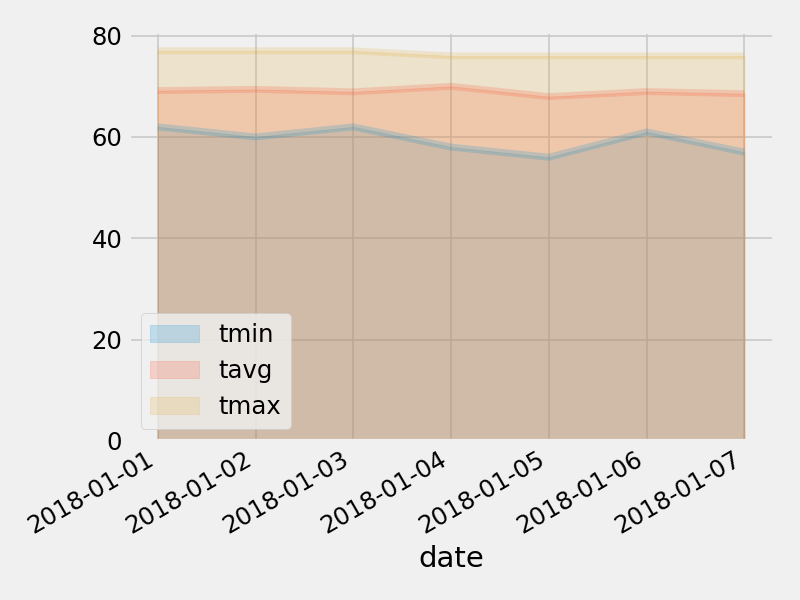

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
